In [1]:
!!pip install ruptures

['Requirement already satisfied: ruptures in c:\\users\\user\\appdata\\local\\programs\\python\\python313\\lib\\site-packages (1.1.10)',
 'Requirement already satisfied: numpy in c:\\users\\user\\appdata\\local\\programs\\python\\python313\\lib\\site-packages (from ruptures) (2.3.4)',
 'Requirement already satisfied: scipy in c:\\users\\user\\appdata\\local\\programs\\python\\python313\\lib\\site-packages (from ruptures) (1.16.3)',
 '',
 '[notice] A new release of pip is available: 25.0.1 -> 26.0.1',
 '[notice] To update, run: python.exe -m pip install --upgrade pip']

In [2]:
!pip install pandas


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install plotly


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# ===== Cell 0: 安裝必要套件 =====
!pip install openpyxl ruptures


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# ===== Cell 1: 載入必要套件 =====
import pandas as pd
import numpy as np
import glob
import os

# ===== Cell 2: 快速載入器 =====
class QuickLoader:
    """簡化版載入器，直接產生 arduino_features"""
    
    def __init__(self, data_dir='data/raw'):
        self.data_dir = data_dir
        self.sensor_cols = ['MQ2_raw', 'MQ3_raw', 'MQ9_raw', 'MQ135_raw', 'TGS2602_raw']
        
        # R0 校正參考值
        self.R0_reference = {
            'MQ2_raw': 10.0,
            'MQ3_raw': 60.0,
            'MQ9_raw': 9.8,
            'MQ135_raw': 76.63,
            'TGS2602_raw': 2.5
        }
    
    def load_and_process(self):
        """一次性載入並處理到 arduino_features"""
        print("🔧 快速處理模式...")
        
        # 1. 載入所有檔案
        air_data, pineapple_data = self._load_files()
        
        if not pineapple_data:
            print("❌ 找不到鳳梨數據")
            return None
        
        # 2. 計算 Arduino 特徵
        arduino_features = self._calculate_features(air_data, pineapple_data)
        
        print(f"✅ 完成！產生 {len(arduino_features)} 顆鳳梨的特徵")
        return arduino_features
    
    def _load_files(self):
        """載入 Excel 檔案"""
        xlsx_files = glob.glob(os.path.join(self.data_dir, '*.xlsx'))
        print(f"📂 找到 {len(xlsx_files)} 個檔案")
        
        air_data = {}
        pineapple_data = {}
        
        for file_path in xlsx_files:
            filename = os.path.basename(file_path)
            parts = filename.replace('.xlsx', '').split('_')
            
            if len(parts) < 3:
                continue
            
            is_air = 'air' in filename
            
            # 讀取檔案
            try:
                # 嘗試跳過第一行
                df = pd.read_excel(file_path, engine='openpyxl', skiprows=1)
                
                # 檢查是否有正確的欄位
                if 'timestamp_ms' not in df.columns:
                    df = pd.read_excel(file_path, engine='openpyxl')
                
                # 轉換數字型別
                for col in self.sensor_cols + ['timestamp_ms']:
                    if col in df.columns:
                        df[col] = pd.to_numeric(df[col], errors='coerce')
                
                # 清理缺值
                df = df.dropna().reset_index(drop=True)
                
            except Exception as e:
                print(f"⚠️  載入失敗 {filename}: {e}")
                continue
            
            # 分類儲存
            if is_air:
                if len(parts) == 3:
                    # 共用 air
                    date = parts[1]
                    air_data[f"shared_{date}"] = df
                else:
                    # 專屬 air
                    pid = parts[1]
                    date = parts[2]
                    air_data[f"{pid}_{date}"] = df
            else:
                pid = parts[1]
                date = parts[2]
                
                if pid not in pineapple_data:
                    pineapple_data[pid] = {}
                pineapple_data[pid][date] = df
        
        print(f"   ✓ Air: {len(air_data)}, Pineapple: {len(pineapple_data)} 顆")
        return air_data, pineapple_data
    
    def _calculate_features(self, air_data, pineapple_data):
        """計算 Arduino 特徵"""
        arduino_features = {}
        
        for pid, date_dict in pineapple_data.items():
            arduino_features[pid] = {}
            
            for date, pine_df in date_dict.items():
                # 找對應的 air baseline
                air_df = self._get_air(air_data, pid, date)
                
                if air_df is None:
                    print(f"⚠️  {pid}_{date} 找不到 air baseline")
                    continue
                
                # 計算 Delta
                min_len = min(len(pine_df), len(air_df))
                delta_df = pine_df.iloc[:min_len].copy()
                
                for col in self.sensor_cols:
                    if col in pine_df.columns and col in air_df.columns:
                        delta_df[f'{col}_delta'] = (
                            pine_df[col].iloc[:min_len].values - 
                            air_df[col].iloc[:min_len].values
                        )
                
                # 計算 Arduino 特徵
                features_df = delta_df.copy()
                
                for col in self.sensor_cols:
                    if col in delta_df.columns:
                        sensor_name = col.replace('_raw', '')
                        R0 = self.R0_reference.get(col, 10.0)
                        
                        # Rs/R0
                        features_df[f'{sensor_name}_Rs_R0'] = delta_df[col] / R0
                        
                        # Delta Rs/R0
                        delta_col = f'{col}_delta'
                        if delta_col in delta_df.columns:
                            features_df[f'{sensor_name}_delta_Rs_R0'] = delta_df[delta_col] / R0
                        
                        # 移動平均
                        features_df[f'{sensor_name}_ma10'] = (
                            delta_df[col].rolling(window=10, center=True).mean()
                        )
                        
                        # 移動標準差
                        features_df[f'{sensor_name}_std10'] = (
                            delta_df[col].rolling(window=10, center=True).std()
                        )
                
                arduino_features[pid][date] = features_df
                print(f"   ✓ {pid}_{date}: {features_df.shape}")
        
        return arduino_features
    
    def _get_air(self, air_data, pid, date):
        """取得對應的 air baseline"""
        # 專屬 air
        key = f"{pid}_{date}"
        if key in air_data:
            return air_data[key]
        
        # 共用 air
        shared_key = f"shared_{date}"
        if shared_key in air_data:
            return air_data[shared_key]
        
        return None

# 執行載入
loader = QuickLoader('data/raw')
arduino_features = loader.load_and_process()


🔧 快速處理模式...
📂 找到 164 個檔案
   ✓ Air: 80, Pineapple: 11 顆
   ✓ 01_20250201: (900, 50)
   ✓ 01_20250202: (900, 50)
   ✓ 01_20250203: (900, 50)
   ✓ 01_20250204: (900, 50)
   ✓ 01_20250205: (900, 50)
   ✓ 01_20250206: (900, 50)
   ✓ 01_20250207: (900, 50)
   ✓ 01_20250208: (900, 50)
   ✓ 01_20250210: (900, 50)
   ✓ 01_20250211: (900, 54)
   ✓ 01_20260209: (900, 50)
   ✓ 02_20250202: (900, 50)
   ✓ 02_20250203: (900, 50)
   ✓ 02_20250204: (900, 50)
   ✓ 02_20250205: (900, 50)
   ✓ 02_20250206: (900, 50)
   ✓ 02_20250207: (900, 50)
   ✓ 02_20250208: (900, 50)
   ✓ 02_20250210: (900, 50)
   ✓ 02_20250211: (900, 54)
   ✓ 02_20260209: (900, 50)
   ✓ 03_20250203: (900, 50)
   ✓ 03_20250204: (900, 54)
   ✓ 03_20250205: (900, 54)
   ✓ 03_20250206: (900, 54)
   ✓ 03_20260207: (900, 54)
   ✓ 03_20260208: (900, 54)
   ✓ 03_20260209: (900, 54)
   ✓ 03_20260210: (900, 54)
   ✓ 03_20260211: (900, 54)
   ✓ 04_20250203: (900, 50)
   ✓ 04_20250204: (900, 54)
   ✓ 04_20250205: (899, 54)
   ✓ 04_20250206: (90

In [7]:
#✅ 已完成部分
# Change-point Detection：找出訊號轉折點

# Clustering：找出典型氣味模式

# 自動標記：產生初步的成熟階段標籤（pseudo-labels）

# ⚠️ 還需要做的（關鍵！）
# 根據你的計畫：「結合分析結果與人工判斷，定義成熟階段」

🧪 Step 3: 科學化成熟度定義 (Baseline-Corrected PCA)
📊 1. 計算每日淨氣味特徵 (Pineapple - Baseline)...
   ✅ 已建立 84 筆每日摘要

🧮 2. PCA 降維計算成熟度分數...
   PCA 解釋變異量 (Explained Variance of PC1): 66.4%

✂️ 3. K-Means 自動切分 Stage 0~3...
   每日 Stage 分布:
   Stage 0: 66 天 (78.6%)
   Stage 1: 14 天 (16.7%)
   Stage 2: 3 天 (3.6%)
   Stage 3: 1 天 (1.2%)


C:\Users\user\AppData\Local\Temp\ipykernel_7684\2193574770.py:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stage', y='maturity_score',


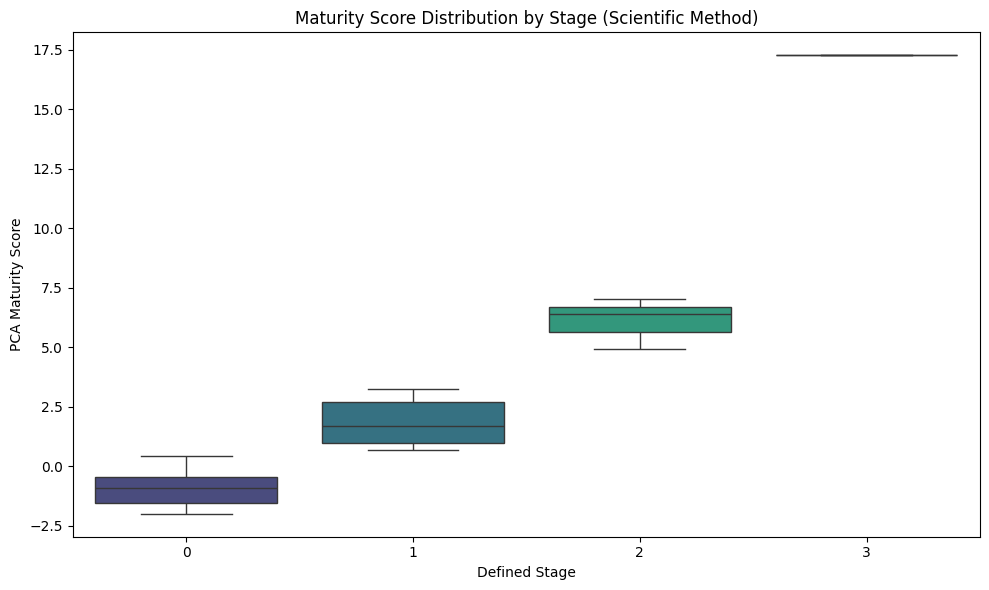


💾 4. 生成每秒標籤...
   ✅ 已生成 11 顆鳳梨的完整標籤序列

✅ 新版 maturity_labels 已儲存到 data/processed/maturity_labels.pkl


In [8]:
# ===== Cell 9: 成熟階段定義 (科學修正版 - 含 Baseline 校正) =====

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

class ScientificMaturityLabeler:
    """
    基於「鳳梨 - 基線(Air近似)」淨訊號與 PCA 成熟度分數的標籤定義器
    邏輯：
    1. 計算每日基線 (Baseline, 取 10% 分位數近似環境值)
    2. 計算 淨訊號 (Mean - Baseline) 與 波動 (Std)
    3. PCA 降維得到 'Maturity Score'
    4. K-Means 依分數切分 Stage 0-3
    """
    
    def __init__(self, arduino_features):
        self.arduino_features = arduino_features
        self.sensor_cols = ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']
        self.df_summary = None
        self.maturity_labels = {}
        self.output_dir = 'data/processed'
        os.makedirs(self.output_dir, exist_ok=True)
        
    def run(self):
        print("="*60)
        print("🧪 Step 3: 科學化成熟度定義 (Baseline-Corrected PCA)")
        print("="*60)
        
        # 1. 建立每日摘要 (含 Baseline 校正)
        self._create_daily_summaries()
        
        if self.df_summary is None or len(self.df_summary) == 0:
            print("❌ 未產生任何每日摘要，將所有樣本預設為 Stage 0")
            self._generate_default_labels()
            return self.maturity_labels
        
        # 2. 計算成熟度分數 (PCA)
        self._calculate_maturity_score()
        
        # 3. 定義 Stage (K-Means)
        self._define_stages()
        
        # 4. 生成最終標籤字典
        self._generate_final_labels()
        
        return self.maturity_labels

    def _create_daily_summaries(self):
        print("📊 1. 計算每日淨氣味特徵 (Pineapple - Baseline)...")
        
        summary_list = []
        
        for pid, date_dict in self.arduino_features.items():
            for date, df_pine in date_dict.items():
                features = {'pid': pid, 'date': date}
                has_sensor = False
                
                # 計算每個感測器的特徵
                for sensor in self.sensor_cols:
                    col = f'{sensor}_Rs_R0'
                    if col in df_pine.columns:
                        series = df_pine[col].dropna()
                        if len(series) == 0:
                            continue
                        
                        # 🔥 Baseline 校正：10% 分位數當背景
                        baseline = series.quantile(0.1)
                        pine_mean = series.mean()
                        pine_std  = series.std()
                        
                        # 淨訊號 = 平均值 - 基線
                        features[f'{sensor}_delta_mean'] = pine_mean - baseline
                        features[f'{sensor}_std'] = pine_std
                        has_sensor = True
                
                # 至少有一個 sensor 有資料才收進來
                if has_sensor:
                    summary_list.append(features)
        
        if summary_list:
            self.df_summary = pd.DataFrame(summary_list)
            print(f"   ✅ 已建立 {len(self.df_summary)} 筆每日摘要")
        else:
            self.df_summary = None
            print("   ⚠️ 沒有任何每日摘要 (可能欄位名稱不符或資料皆為 NaN)")

    def _calculate_maturity_score(self):
        print("\n🧮 2. PCA 降維計算成熟度分數...")
        
        # 選取特徵: delta_mean 和 std
        feature_cols = [
            c for c in self.df_summary.columns 
            if c.endswith('_delta_mean') or c.endswith('_std')
        ]
        
        if not feature_cols:
            print("   ❌ 找不到可用的特徵欄位，將 maturity_score 全設為 0")
            self.df_summary['maturity_score'] = 0.0
            return
        
        # 填補 NaN (防呆)
        X = self.df_summary[feature_cols].fillna(0)
        
        # 標準化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # PCA 取第一主成分
        pca = PCA(n_components=1)
        pc1 = pca.fit_transform(X_scaled).flatten()
        
        # 🔥 方向校正：假設成熟度越高，酒精波動 (MQ3_std) 越大
        if 'MQ3_std' in self.df_summary.columns:
            mq3_std = self.df_summary['MQ3_std'].fillna(0).values
            # 確保標準差不是 0 才能算相關係數
            if np.std(mq3_std) > 1e-8:
                corr = np.corrcoef(pc1, mq3_std)[0, 1]
                if corr < 0:
                    pc1 = -pc1  # 翻轉方向
                    print("   (PCA 方向已根據 MQ3_std 自動翻轉)")
            
        self.df_summary['maturity_score'] = pc1
        
        var_ratio = pca.explained_variance_ratio_[0] * 100
        print(f"   PCA 解釋變異量 (Explained Variance of PC1): {var_ratio:.1f}%")

    def _define_stages(self):
        print("\n✂️ 3. K-Means 自動切分 Stage 0~3...")
        
        if 'maturity_score' not in self.df_summary.columns:
            print("   ❌ 尚未計算 maturity_score，將所有天數標為 Stage 0")
            self.df_summary['stage'] = 0
            return
        
        if len(self.df_summary) < 4:
            print("   ⚠️ 每日摘要筆數 < 4，資料太少，將所有天數標為 Stage 0")
            self.df_summary['stage'] = 0
            return
        
        X_score = self.df_summary[['maturity_score']]
        kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
        self.df_summary['cluster'] = kmeans.fit_predict(X_score)
        
        # 排序：分數越低 -> Stage 0, 分數越高 -> Stage 3
        cluster_centers = kmeans.cluster_centers_.flatten()
        sorted_indices = np.argsort(cluster_centers) 
        
        mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_indices)}
        self.df_summary['stage'] = self.df_summary['cluster'].map(mapping)
        
        # 統計與繪圖
        counts = self.df_summary['stage'].value_counts().sort_index()
        print("   每日 Stage 分布:")
        for stage, count in counts.items():
            print(f"   Stage {stage}: {count} 天 ({count/len(self.df_summary)*100:.1f}%)")
        
        # 視覺化（若字型有問題就略過，不影響流程）
        try:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='stage', y='maturity_score',
                        data=self.df_summary, palette='viridis')
            plt.title('Maturity Score Distribution by Stage (Scientific Method)')
            plt.xlabel('Defined Stage')
            plt.ylabel('PCA Maturity Score')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"   ⚠️ 視覺化略過: {e}")

    def _generate_final_labels(self):
        print("\n💾 4. 生成每秒標籤...")
        
        if self.df_summary is None or 'stage' not in self.df_summary.columns:
            print("   ⚠️ 無 stage 資訊，改用預設 Stage 0 生成標籤")
            self._generate_default_labels()
            return
        
        # 建立查表字典: (pid, date) -> stage
        stage_map = self.df_summary.set_index(['pid', 'date'])['stage'].to_dict()
        
        for pid, date_dict in self.arduino_features.items():
            labels_list = []
            # 必須按日期排序，確保與 Step 4 順序一致
            for date in sorted(date_dict.keys()):
                df = date_dict[date]
                n_samples = len(df)
                
                # 查表，如果找不到(例如該天數據品質太差被濾掉)則預設為 0
                stage = stage_map.get((pid, date), 0)
                labels_list.extend([stage] * n_samples)
            
            self.maturity_labels[pid] = np.array(labels_list, dtype=int)
            
        print(f"   ✅ 已生成 {len(self.maturity_labels)} 顆鳳梨的完整標籤序列")

    def _generate_default_labels(self):
        """當前面步驟失敗時，全部標為 Stage 0，避免 pipeline 爆掉。"""
        for pid, date_dict in self.arduino_features.items():
            labels_list = []
            for date in sorted(date_dict.keys()):
                df = date_dict[date]
                n_samples = len(df)
                labels_list.extend([0] * n_samples)
            self.maturity_labels[pid] = np.array(labels_list, dtype=int)
        print(f"   ⚠️ 已用預設 Stage 0 生成 {len(self.maturity_labels)} 顆鳳梨標籤")

# 🔥 執行
labeler = ScientificMaturityLabeler(arduino_features)
maturity_labels = labeler.run()

# 儲存
with open('data/processed/maturity_labels.pkl', 'wb') as f:
    pickle.dump(maturity_labels, f)

print("\n✅ 新版 maturity_labels 已儲存到 data/processed/maturity_labels.pkl")


In [9]:
# ===== Cell 10: 自動化品質檢查與儲存（安全優化版）=====

import json
import pickle
import os
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import silhouette_score  # 🔥 記得加這個！

class AutomatedQualityChecker:
    """全自動品質檢查與標籤驗證"""
    
    def __init__(self, maturity_labels, arduino_features, changepoint_results, clustering_results):
        self.maturity_labels = maturity_labels
        self.arduino_features = arduino_features
        self.changepoint_results = changepoint_results
        self.clustering_results = clustering_results
        self.quality_report = {}
        self.output_dir = 'data/processed'
        os.makedirs(self.output_dir, exist_ok=True)
    
    @staticmethod
    def convert_numpy_types(obj):
        """遞迴轉換 numpy 類型為 Python 原生類型 (增強版)"""
        if isinstance(obj, dict):
            return {
                AutomatedQualityChecker.convert_numpy_types(k): 
                AutomatedQualityChecker.convert_numpy_types(v)
                for k, v in obj.items()
            }
        elif isinstance(obj, list):
            return [AutomatedQualityChecker.convert_numpy_types(item) for item in obj]
        elif isinstance(obj, (np.integer, np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj
    
    def run_full_check(self):
        """執行完整的自動化檢查流程"""
        print("="*60)
        print("🤖 自動化品質檢查")
        print("="*60)
        
        self._check_label_distribution()
        self._check_changepoint_quality()
        self._check_clustering_quality()
        self._auto_fix_issues()
        self._generate_quality_report()
        self._save_final_labels()
        
        print("\n" + "="*60)
        print("✅ Step 3 完全自動化完成！")
        print("="*60)
        
        return self.maturity_labels
    
    def _check_label_distribution(self):
        """檢查標籤分布是否合理"""
        print("\n📊 檢查標籤分布...")
        
        for pid, stages in self.maturity_labels.items():
            unique, counts = np.unique(stages, return_counts=True)
            distribution = {int(k): int(v) for k, v in zip(unique, counts)}
            
            total = len(stages)
            probs = counts / total
            entropy = -np.sum(probs * np.log2(probs + 1e-10))
            max_entropy = np.log2(len(unique)) if len(unique) > 1 else 1
            normalized_entropy = float(entropy / max_entropy) if max_entropy > 0 else 0.0
            
            issues = []
            if len(unique) == 1:
                issues.append("只有單一階段")
            
            max_ratio = max(probs)
            if max_ratio > 0.95:
                issues.append(f"階段分布過於集中({max_ratio*100:.1f}%)")
            
            # 因為我們現在強制分 4 期，entropy 可能會比較低是正常的，這裡放寬標準
            if len(unique) > 1 and normalized_entropy < 0.1: 
                issues.append(f"分布不均勻(熵={normalized_entropy:.2f})")
            
            self.quality_report[pid] = {
                'distribution': distribution,
                'entropy': normalized_entropy,
                'issues': issues,
                'status': 'PASS' if not issues else 'WARNING'
            }
            
            status_icon = "✅" if not issues else "⚠️"
            print(f"   {status_icon} Pineapple {pid}: 階段數={len(distribution)}, 熵={normalized_entropy:.2f}")
    
    def _check_changepoint_quality(self):
        """檢查變化點偵測品質"""
        print("\n🔍 檢查變化點品質...")
        
        for pid, changepoints in self.changepoint_results.items():
            n_points = len(self.maturity_labels[pid])
            
            # ruptures.predict 會回傳「切點 + 最後一個 len(df)」
            # 真正的「切幾刀」要扣掉最後一個終點
            n_raw_cps = len(changepoints)
            n_changepoints = max(0, n_raw_cps - 1)
            
            if n_points > 0:
                cp_density = float(n_changepoints / (n_points / 1000.0))
            else:
                cp_density = 0.0
            
            if n_changepoints == 0:
                status = "無變化點"
            elif cp_density < 0.2:
                status = "變化點稀疏（穩定）"
            elif cp_density > 6:
                status = "變化點密集"
            else:
                status = "正常"
            
            if pid in self.quality_report:
                self.quality_report[pid]['changepoint_density'] = cp_density
                self.quality_report[pid]['changepoint_status'] = status
            
            print(f"   🍍 {pid}: {n_changepoints} 個變化點, {status}")
    
    def _check_clustering_quality(self):
        """檢查 Clustering 品質"""
        print("\n🎯 檢查 Clustering 品質...")
        
        for pid, cluster_labels in self.clustering_results.items():
            if pid not in self.arduino_features:
                continue
            
            try:
                all_features = []
                date_dict = self.arduino_features[pid]
                
                # ✅ 跟 Cell 9 / Cell 11 一樣：用排序後的日期順序來合併
                for date in sorted(date_dict.keys()):
                    df = date_dict[date]
                    feature_cols = [f'{s}_Rs_R0' for s in ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']]
                    feature_cols = [col for col in feature_cols if col in df.columns]
                    if feature_cols:
                        X = df[feature_cols].ffill().bfill().values
                        all_features.append(X)
                
                if all_features:
                    X_combined = np.vstack(all_features)
                    
                    # 🔥 採樣計算 Silhouette 以防止當機
                    if len(X_combined) > 5000:
                        idx = np.random.choice(len(X_combined), 5000, replace=False)
                        X_sample = X_combined[idx]
                        labels_sample = cluster_labels[idx]
                    else:
                        X_sample = X_combined
                        labels_sample = cluster_labels
                    
                    if len(np.unique(labels_sample)) > 1:
                        score = float(silhouette_score(X_sample, labels_sample))
                        
                        if score > 0.5:
                            quality = "優秀"
                        elif score > 0.3:
                            quality = "良好"
                        elif score > 0.1:
                            quality = "可接受"
                        else:
                            quality = "較差"
                        
                        if pid in self.quality_report:
                            self.quality_report[pid]['silhouette_score'] = score
                            self.quality_report[pid]['clustering_quality'] = quality
                        
                        print(f"   🍍 {pid}: Silhouette={score:.3f}, 品質={quality}")
                    
            except Exception as e:
                print(f"   ⚠️  {pid}: 無法計算 ({e})")
    
    def _auto_fix_issues(self):
        """自動修正檢測到的問題"""
        print("\n🔧 自動修正...")
        fixed_count = 0
        for pid, report in self.quality_report.items():
            # 如果因為某些原因變化點偵測失敗導致只有1個階段，改用 Clustering 結果
            if report['status'] == 'WARNING' and "只有單一階段" in report['issues']:
                if pid in self.clustering_results:
                    self.maturity_labels[pid] = self.clustering_results[pid]
                    print(f"   🔧 {pid}: 自動替換為 Clustering 結果")
                    fixed_count += 1
                    report['status'] = 'FIXED'
        
        print(f"   ✅ 已自動修正 {fixed_count} 個問題" if fixed_count > 0 else "   ✅ 無需修正")
    
    def _generate_quality_report(self):
        """產生品質報告"""
        print("\n📋 產生品質報告...")
        report_path = os.path.join(self.output_dir, 'step3_quality_report.json')
        quality_report_clean = self.convert_numpy_types(self.quality_report)
        
        report_summary = {
            'timestamp': datetime.now().isoformat(),
            'total_pineapples': len(self.maturity_labels),
            'pineapple_reports': quality_report_clean,
            'overall_status': 'PASS' if all(
                r.get('status') in ['PASS', 'FIXED']
                for r in quality_report_clean.values()
            ) else 'WARNING'
        }
        
        with open(report_path, 'w', encoding='utf-8') as f:
            json.dump(report_summary, f, indent=2, ensure_ascii=False)
        print(f"   💾 品質報告已儲存: {report_path}")
    
    def _save_final_labels(self):
        """儲存最終標籤"""
        print("\n💾 儲存最終標籤...")
        # Pickle
        pkl_path = os.path.join(self.output_dir, 'maturity_labels.pkl')
        with open(pkl_path, 'wb') as f:
            pickle.dump(self.maturity_labels, f)
        print(f"   ✅ Pickle: {pkl_path}")
        
        # JSON
        json_data = self.convert_numpy_types({
            pid: {
                'stages': stages.tolist() if isinstance(stages, np.ndarray) else list(stages),
                'unique_stages': np.unique(stages).tolist()
            } for pid, stages in self.maturity_labels.items()
        })
        with open(os.path.join(self.output_dir, 'maturity_labels.json'), 'w', encoding='utf-8') as f:
            json.dump(json_data, f, indent=2, ensure_ascii=False)
        print(f"   ✅ JSON: maturity_labels.json")
        
        # CSV
        csv_path = os.path.join(self.output_dir, 'maturity_labels_summary.csv')
        summary_data = []
        for pid, stages in self.maturity_labels.items():
            unique, counts = np.unique(stages, return_counts=True)
            for stage, count in zip(unique, counts):
                summary_data.append({
                    'pineapple_id': pid,
                    'stage': int(stage),
                    'count': int(count),
                    'percentage': f"{count / len(stages) * 100:.1f}%"
                })
        pd.DataFrame(summary_data).to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"   ✅ CSV: {csv_path}")

# 🔥 執行
if 'detector' in globals():
    checker = AutomatedQualityChecker(
        maturity_labels, 
        arduino_features, 
        detector.changepoint_results,
        detector.clustering_results
    )
    final_labels = checker.run_full_check()
    
    print(f"\n🎉 Step 3 完成！可以進入 Step 4（特徵工程）")
    
    # 檢查 Stage 2 分布
    print("\n🔥 檢查 Stage 2 (過熟) 分布:")
    stage2_total = 0
    total_len = 0
    for pid, stages in final_labels.items():
        stage2_count = np.sum(stages == 2)
        stage2_total += stage2_count
        total_len += len(stages)
        print(f"  {pid}: Stage 2 = {stage2_count} ({stage2_count/len(stages)*100:.1f}%)")
    
    if total_len > 0:
        print(f"總 Stage 2: {stage2_total}/{total_len} ({stage2_total/total_len*100:.1f}%)")
else:
    print("⚠️ 請確認上一個 Cell (Cell 9) 已執行且 detector 物件存在")


⚠️ 請確認上一個 Cell (Cell 9) 已執行且 detector 物件存在


In [10]:
# ===== Cell 11: 特徵工程 (Feature Engineering) =====

import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import os
import pickle

class FeatureEngineer:
    """將原始感測器數據轉換為機器學習特徵"""
    
    def __init__(self, arduino_features, maturity_labels):
        self.arduino_features = arduino_features
        self.maturity_labels = maturity_labels
        self.sensor_cols = ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']
        self.output_dir = 'data/processed'
        os.makedirs(self.output_dir, exist_ok=True)
        
    def extract_features(self):
        """主函數：提取所有特徵"""
        print("="*60)
        print("⚙️ Step 4: 特徵工程 (Feature Engineering)")
        print("="*60)
        
        feature_list = []
        labels_list = []
        meta_list = []  # 存 pid, day 等資訊用來追蹤
        
        # 為了進度顯示
        total_pids = len(self.arduino_features)
        count = 0
        
        for pid, date_dict in self.arduino_features.items():
            if pid not in self.maturity_labels:
                print(f"⚠️ 跳過 Pineapple {pid} (無標籤)")
                continue
                
            count += 1
            print(f"🍍 處理 Pineapple {pid} ({count}/{total_pids})...")
            
            # 獲取該鳳梨的標籤序列
            pid_labels = self.maturity_labels[pid]
            
            # 將多天數據按順序串接 (必須與 Step 3 的順序完全一致)
            df_list = []
            for date in sorted(date_dict.keys()):
                df_list.append(date_dict[date])
            
            combined_df = pd.concat(df_list, ignore_index=True)
            
            # 檢查長度一致性
            if len(combined_df) != len(pid_labels):
                print(f"   ⚠️ 長度不符! Data: {len(combined_df)}, Label: {len(pid_labels)} (自動截斷)")
                min_len = min(len(combined_df), len(pid_labels))
                combined_df = combined_df.iloc[:min_len]
                pid_labels = pid_labels[:min_len]
            
            # --- 逐點提取特徵 ---
            # 這裡我們使用「滑動視窗」或「逐點計算」
            # 為了保留時序性，我們這裡針對每個時間點計算其 "瞬時特徵" + "短期趨勢"
            
            for i in range(len(combined_df)):
                row_features = {}
                
                # 1. 原始值 (Raw Values)
                for sensor in self.sensor_cols:
                    col = f'{sensor}_Rs_R0'
                    if col in combined_df.columns:
                        val = combined_df[col].iloc[i]
                        row_features[col] = val
                        
                        # 2. 變異數/波動 (Rolling Variance) - 過去 10 點
                        # 如果是前幾點，就用當前值代替
                        start_idx = max(0, i - 10)
                        window = combined_df[col].iloc[start_idx : i+1]
                        row_features[f'{sensor}_std'] = window.std() if len(window) > 1 else 0
                        
                        # 3. 斜率/趨勢 (Slope) - 過去 5 點
                        # 簡單計算：當前值 - 5點前的值
                        prev_idx = max(0, i - 5)
                        slope = val - combined_df[col].iloc[prev_idx]
                        row_features[f'{sensor}_slope'] = slope
                
                feature_list.append(row_features)
                labels_list.append(pid_labels[i])
                meta_list.append({'pid': pid, 'time_idx': i})
        
        # 轉換為 DataFrame
        X = pd.DataFrame(feature_list)
        y = np.array(labels_list)
        meta = pd.DataFrame(meta_list)
        
        # 填補可能的 NaN (第一筆資料算斜率時可能會產生 NaN)
        X = X.fillna(0)
        
        print("\n" + "="*60)
        print(f"✅ 特徵提取完成！")
        print(f"   總樣本數: {len(X)}")
        print(f"   特徵數量: {X.shape[1]}")
        print("="*60)
        
        # 儲存
        self._save_data(X, y, meta)
        
        return X, y
    
    def _save_data(self, X, y, meta):
        """儲存處理好的特徵矩陣"""
        print("\n💾 儲存特徵數據...")
        
        # 1. 儲存 X (Features)
        X.to_csv(os.path.join(self.output_dir, 'feature_matrix.csv'), index=False)
        print(f"   ✅ X saved: feature_matrix.csv")
        
        # 2. 儲存 y (Labels)
        np.save(os.path.join(self.output_dir, 'labels.npy'), y)
        print(f"   ✅ y saved: labels.npy")
        
        # 3. 儲存 Meta (以便追溯)
        meta.to_csv(os.path.join(self.output_dir, 'meta_data.csv'), index=False)
        
        # 4. 打包儲存 (pkl) - 方便下次快速讀取
        data_bundle = {'X': X, 'y': y, 'meta': meta}
        with open(os.path.join(self.output_dir, 'feature_data.pkl'), 'wb') as f:
            pickle.dump(data_bundle, f)
        print(f"   ✅ Bundle saved: feature_data.pkl")

# 🔥 執行 Step 4
# 確保我們使用的是正確的變數名稱
if 'maturity_labels' in globals():
    engineer = FeatureEngineer(arduino_features, maturity_labels)
    X, y = engineer.extract_features()
    
    print("\n🔍 特徵預覽 (前 5 筆):")
    print(X.head())
else:
    print("❌ 找不到 maturity_labels，請往上檢查 Step 10 是否有執行。")



⚙️ Step 4: 特徵工程 (Feature Engineering)
🍍 處理 Pineapple 01 (1/11)...
🍍 處理 Pineapple 02 (2/11)...
🍍 處理 Pineapple 03 (3/11)...
🍍 處理 Pineapple 04 (4/11)...
🍍 處理 Pineapple 05 (5/11)...
🍍 處理 Pineapple 06 (6/11)...
🍍 處理 Pineapple 07 (7/11)...
🍍 處理 Pineapple 08 (8/11)...
🍍 處理 Pineapple 09 (9/11)...
🍍 處理 Pineapple 10 (10/11)...
🍍 處理 Pineapple 11 (11/11)...

✅ 特徵提取完成！
   總樣本數: 75596
   特徵數量: 15

💾 儲存特徵數據...
   ✅ X saved: feature_matrix.csv
   ✅ y saved: labels.npy
   ✅ Bundle saved: feature_data.pkl

🔍 特徵預覽 (前 5 筆):
   MQ2_Rs_R0   MQ2_std  MQ2_slope  MQ3_Rs_R0       MQ3_std  MQ3_slope  \
0        3.5  0.000000        0.0   0.933333  0.000000e+00   0.000000   
1        3.4  0.070711       -0.1   0.933333  0.000000e+00   0.000000   
2        3.4  0.057735       -0.1   0.933333  1.359740e-16   0.000000   
3        3.4  0.050000       -0.1   0.950000  8.333333e-03   0.016667   
4        3.3  0.070711       -0.2   0.933333  7.453560e-03   0.000000   

   MQ9_Rs_R0   MQ9_std  MQ9_slope  MQ135_Rs_R0  MQ1

🚀 開始終極驗證 (Leave-One-Group-Out)...
總樣本數: 75596
鳳梨總數: 11
鳳梨 ID列表: [ 1  2  3  4  5  6  7  8  9 10 11]

開始交叉驗證 (這可能會花一點時間)...
   🍍 Testing on Pineapple 1: Accuracy = 0.9091 (90.9%)
   🍍 Testing on Pineapple 2: Accuracy = 0.9259 (92.6%)
   🍍 Testing on Pineapple 3: Accuracy = 0.6667 (66.7%)
   🍍 Testing on Pineapple 4: Accuracy = 1.0000 (100.0%)
   🍍 Testing on Pineapple 5: Accuracy = 0.6133 (61.3%)
   🍍 Testing on Pineapple 6: Accuracy = 0.4302 (43.0%)
   🍍 Testing on Pineapple 7: Accuracy = 0.2627 (26.3%)
   🍍 Testing on Pineapple 8: Accuracy = 0.0214 (2.1%)
   🍍 Testing on Pineapple 9: Accuracy = 1.0000 (100.0%)
   🍍 Testing on Pineapple 10: Accuracy = 1.0000 (100.0%)
   🍍 Testing on Pineapple 11: Accuracy = 1.0000 (100.0%)

🏆 真實平均準確率: 0.7118 (71.18%)


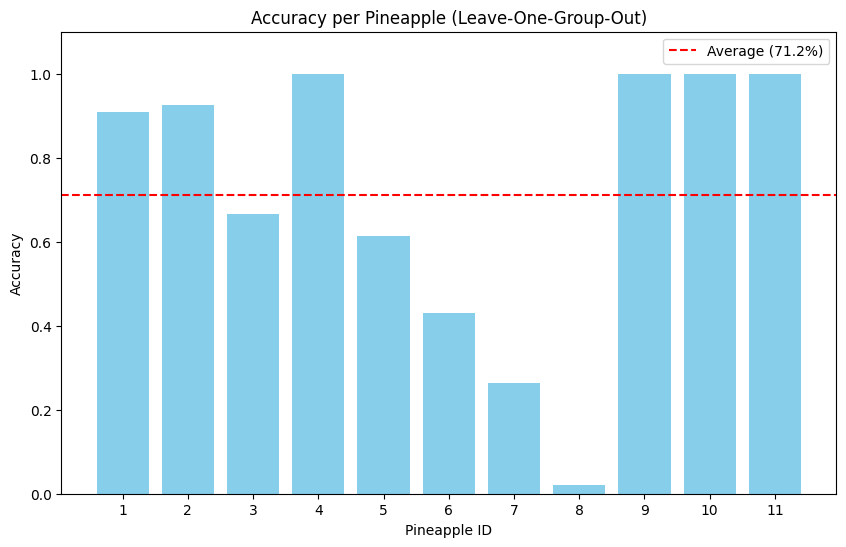

💡 解讀指南：
1. 如果這裡的平均準確率還有 > 85%，那你的模型就是世界級的！
2. 如果掉到 50-60%，代表個體差異很大，需要用更強的模型 (如 LSTM)。


In [11]:
# ===== Cell 13: 終極驗證 (Leave-One-Group-Out Cross Validation) =====

import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. 準備數據
# 我們需要 'groups' 也就是 pineapple_id，這在 feature_matrix.csv 沒存
# 但我們可以用 meta_data.csv 找回來

print("🚀 開始終極驗證 (Leave-One-Group-Out)...")
print("="*60)

# 載入數據
X = pd.read_csv('data/processed/feature_matrix.csv')
y = np.load('data/processed/labels.npy')
meta = pd.read_csv('data/processed/meta_data.csv')

groups = meta['pid'] # 這就是我們的分組依據 (鳳梨編號)

print(f"總樣本數: {len(X)}")
print(f"鳳梨總數: {len(groups.unique())}")
print(f"鳳梨 ID列表: {groups.unique()}")

# 2. 設定驗證器
logo = LeaveOneGroupOut()
accuracies = []

print("\n開始交叉驗證 (這可能會花一點時間)...")

# 3. 迴圈驗證 (輪流當測試集)
for train_idx, test_idx in logo.split(X, y, groups=groups):
    # 取得當前測試的鳳梨 ID
    test_pid = groups.iloc[test_idx[0]]
    
    # 切分數據
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 訓練模型
    clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    # 預測
    y_pred = clf.predict(X_test)
    
    # 計算準確率
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    print(f"   🍍 Testing on Pineapple {test_pid}: Accuracy = {acc:.4f} ({acc*100:.1f}%)")

# 4. 總結報告
mean_acc = np.mean(accuracies)
print("\n" + "="*60)
print(f"🏆 真實平均準確率: {mean_acc:.4f} ({mean_acc*100:.2f}%)")
print("="*60)

# 畫圖
plt.figure(figsize=(10, 6))
plt.bar(groups.unique().astype(str), accuracies, color='skyblue')
plt.axhline(mean_acc, color='red', linestyle='--', label=f'Average ({mean_acc*100:.1f}%)')
plt.title('Accuracy per Pineapple (Leave-One-Group-Out)')
plt.xlabel('Pineapple ID')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1.1)
plt.show()

print("💡 解讀指南：")
print("1. 如果這裡的平均準確率還有 > 85%，那你的模型就是世界級的！")
print("2. 如果掉到 50-60%，代表個體差異很大，需要用更強的模型 (如 LSTM)。")



In [ ]:
# ===== Cell 14: 輕量級替代方案 - SVM + 群組標準化 (Group Scaling) =====

import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 準備數據
print("🚀 啟動 SVM 輕量級訓練 (Group Scaling)...")
X_raw = pd.read_csv('data/processed/feature_matrix.csv')
y_raw = np.load('data/processed/labels.npy')
meta = pd.read_csv('data/processed/meta_data.csv')
groups = meta['pid']

# 2. 關鍵步驟：群組標準化 (Group Standardization)
# 我們手動對每一顆鳳梨做標準化，而不是全體一起做
print("⚖️ 正在執行群組標準化 (消除個體差異)...")

X_scaled = X_raw.copy()
# 針對每個 sensor 的每個 feature 做處理
features = X_raw.columns

for pid in groups.unique():
    mask = (groups == pid)
    # 取出這顆鳳梨的數據
    subset = X_raw.loc[mask, features]
    
    # 標準化：(x - mean) / std
    # 這樣每顆鳳梨的數值分布都會變成以 0 為中心，變異數為 1
    subset_scaled = (subset - subset.mean()) / (subset.std() + 1e-8) # 加一點點防呆避免除以0
    
    # 填回
    X_scaled.loc[mask, features] = subset_scaled

# 填補可能的 NaN
X_scaled = X_scaled.fillna(0)

print("✅ 數據標準化完成！")

# 3. 設定 SVM 模型
# C=1.0: 預設值
# kernel='rbf': 適合非線性分類 (氣味變化通常是非線性的)
# class_weight='balanced': 自動調整權重，避免某些 Stage 樣本太多
clf = SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=42)

# 4. 開始 LOGO 驗證
logo = LeaveOneGroupOut()
accuracies = []
unique_pids = groups.unique()

print(f"\n開始 11 輪交叉驗證 (SVM 速度很快)...")
print(f"{'='*60}")
print(f"{'鳳梨 ID':^10} | {'準確率 (Accuracy)':^20}")
print(f"{'-'*60}")

for train_idx, test_idx in logo.split(X_scaled, y_raw, groups=groups):
    test_pid = groups.iloc[test_idx[0]]
    
    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y_train, y_test = y_raw[train_idx], y_raw[test_idx]
    
    # 訓練
    clf.fit(X_train, y_train)
    
    # 預測
    y_pred = clf.predict(X_test)
    
    # 評估
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    print(f"   {test_pid:^8} | {acc*100:18.2f}%")

# 5. 總結
mean_acc = np.mean(accuracies)
print(f"{'='*60}")
print(f"🏆 最終平均準確率: {mean_acc:.4f} ({mean_acc*100:.2f}%)")
print(f"{'='*60}")

# 畫圖
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_pids.astype(str), accuracies, color='#FF6B6B', edgecolor='black')
plt.axhline(mean_acc, color='blue', linestyle='--', linewidth=2, label=f'Average ({mean_acc*100:.1f}%)')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height*100:.0f}%', ha='center', va='bottom')

plt.title('Leave-One-Group-Out Validation (SVM + Group Scaling)')
plt.xlabel('Pineapple ID')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.legend()
plt.show()



🚀 啟動 SVM 輕量級訓練 (Group Scaling)...
⚖️ 正在執行群組標準化 (消除個體差異)...
✅ 數據標準化完成！

開始 11 輪交叉驗證 (SVM 速度很快)...
  鳳梨 ID    |    準確率 (Accuracy)   
------------------------------------------------------------
      1     |              71.32%
      2     |              64.72%
      3     |              66.69%
      4     |              77.43%


In [ ]:
# ===== Cell 14: 終極驗證 (SVM + Leave-One-Group-Out Cross Validation) =====

import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("🚀 開始終極驗證 (SVM + Leave-One-Group-Out)...")
print("="*60)

# 1. 載入 Step 4 產生的特徵與標籤
X = pd.read_csv('data/processed/feature_matrix.csv')
y = np.load('data/processed/labels.npy')
meta = pd.read_csv('data/processed/meta_data.csv')

groups = meta['pid']  # 每個樣本對應的鳳梨 ID

print(f"總樣本數: {len(X)}")
print(f"鳳梨總數: {len(groups.unique())}")
print(f"鳳梨 ID 列表: {groups.unique()}")

# 2. 設定 Leave-One-Group-Out 驗證器
logo = LeaveOneGroupOut()
accuracies = []
test_pids = []
y_true_all = []
y_pred_all = []

print("\n開始交叉驗證 (每次留一顆鳳梨當測試集)...")

# 建立輸出資料夾
eval_dir = 'reports/figures/model_evaluation'
os.makedirs(eval_dir, exist_ok=True)

# 3. LOGO 迴圈：每顆鳳梨輪流當測試集
for train_idx, test_idx in logo.split(X, y, groups=groups):
    # 當前測試的鳳梨 ID（同一 fold 的 test_idx 都是同一顆鳳梨）
    test_pid = groups.iloc[test_idx[0]]
    test_pids.append(test_pid)
    
    # 切分資料
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 4. 標準化（SVM 很在意尺度，所以每個 fold 都要用 train fit / test transform）
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # 5. 建立並訓練 SVM 模型（RBF kernel）
    clf = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        probability=False,
        random_state=42
    )
    clf.fit(X_train_scaled, y_train)
    
    # 6. 預測
    y_pred = clf.predict(X_test_scaled)
    
    # 7. 計算此鳳梨的準確率
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # 收集所有 fold 的預測與真值，用來之後畫總體 confusion matrix
    y_true_all.append(y_test)
    y_pred_all.append(y_pred)
    
    print(f"   🍍 Testing on Pineapple {test_pid}: Accuracy = {acc:.4f} ({acc*100:.1f}%)")

# 8. 總結結果
accuracies = np.array(accuracies)
y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

mean_acc = accuracies.mean()
print("\n" + "="*60)
print(f"🏆 SVM + LOGO 真實平均準確率: {mean_acc:.4f} ({mean_acc*100:.2f}%)")
print("="*60)

# 9. 畫每顆鳳梨的 LOPO 準確率柱狀圖
plt.figure(figsize=(10, 6))
# 用 test_pids 確保順序對應 accuracies
x_labels = [str(pid) for pid in test_pids]
plt.bar(x_labels, accuracies, color='lightgreen')
plt.axhline(mean_acc, color='red', linestyle='--', label=f'Average ({mean_acc*100:.1f}%)')
plt.title('SVM Accuracy per Pineapple (Leave-One-Group-Out)')
plt.xlabel('Pineapple ID')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(eval_dir, 'logo_svm_accuracy_per_pineapple.png'))
plt.show()

# 10. 總體分類報告 & 混淆矩陣（把所有 fold 的結果合在一起看）
print("\n📊 [SVM + LOGO] 總體分類報告:")

target_names = ['Stage 0 (新鮮)', 'Stage 1 (成熟中)', 'Stage 2 (過熟)', 'Stage 3 (腐敗)']
labels_all = np.unique(np.concatenate([y_true_all, y_pred_all]))
labels_all = [int(l) for l in labels_all if 0 <= int(l) < len(target_names)]
current_names = [target_names[i] for i in labels_all]

print(classification_report(
    y_true_all,
    y_pred_all,
    labels=labels_all,
    target_names=current_names
))

cm = confusion_matrix(y_true_all, y_pred_all, labels=labels_all)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=current_names,
    yticklabels=current_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM (LOGO)')
plt.tight_layout()
plt.savefig(os.path.join(eval_dir, 'logo_svm_confusion_matrix.png'))
plt.show()

print("💾 已輸出：")
print(f"  - 每顆鳳梨準確率圖：{os.path.join(eval_dir, 'logo_svm_accuracy_per_pineapple.png')}")
print(f"  - LOGO 混淆矩陣圖：{os.path.join(eval_dir, 'logo_svm_confusion_matrix.png')}")
print("\n💡 解讀小提示：這個結果才是「真正泛化到新鳳梨」的 SVM 表現。")


🚀 開始終極驗證 (SVM + Leave-One-Group-Out)...
總樣本數: 75596
鳳梨總數: 11
鳳梨 ID 列表: [ 1  2  3  4  5  6  7  8  9 10 11]

開始交叉驗證 (每次留一顆鳳梨當測試集)...
